### Library Imports 

In [392]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


### Data Loading

In [393]:
df = pd.read_csv('credit_messy.csv')


In [394]:
df.columns

Index(['ID', 'CreditLimit', 'Gender', 'Education', 'MaritalStatus', 'Age',
       'RepayStatApr', 'RepayStatMay', 'RepayStatJun', 'RepayStatJul',
       'RepayStatAug', 'RepayStatSep', 'BillSep', 'BillAug', 'BillJul',
       'BillJun', 'BillMay', 'BillApr', 'PaymentSep', 'PaymentAug',
       'PaymentJul', 'PaymentJun', 'PaymentMay', 'PaymentApr', 'Default'],
      dtype='object')

In [395]:
df.head()

,ID,CreditLimit,Gender,Education,MaritalStatus,Age,RepayStatApr,RepayStatMay,RepayStatJun,RepayStatJul,...,BillJun,BillMay,BillApr,PaymentSep,PaymentAug,PaymentJul,PaymentJun,PaymentMay,PaymentApr,Default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Initial data exploration 

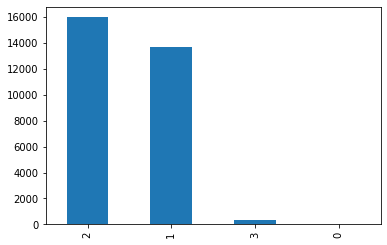

In [396]:
df.MaritalStatus.value_counts().plot(kind='bar')

In [397]:
df.MaritalStatus.value_counts()

2    15964
1    13659
3      323
0       54
Name: MaritalStatus, dtype: int64

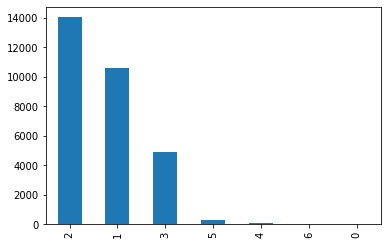

In [398]:
df.Education.value_counts().plot(kind='bar')

In [399]:
df.Education.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: Education, dtype: int64

In [400]:
# Either mislabelled or incorrect data (marriage = 0, Education = 0)
# Given this is such a small proportion of our set, i've decided to drop the rows containing this information

to_drop = (df.loc[(df.Education > 4 )|(df.Education == 0) ]).index
to_drop_again = (full_df.loc[full_df.MaritalStatus == 0]).index
df = df.drop(to_drop)
df = df.drop(to_drop_again)

In [401]:
df.columns =['ID','CreditLimit','Gender','Education','MaritalStatus','Age',
        'RepayStatSep','RepayStatAug','RepayStatJul','RepayStatJun','RepayStatMay','RepayStatApr',
        'BillSep','BillAug','BillJul','BillJun','BillMay','BillApr',
        'PrevPaymentSep','PrevPaymentAug','PrevPaymentJul','PrevPaymentJun','PrevPaymentMay','PrevPaymentApr',
        'Default']



### Getting a feel for the distribution of the data to analyse points for feature engineering

The following cell will help us interpret our EDA by mapping the categorical variables based on the columns values

In [402]:
gender_dict ={1:'male', 2:'female'}
education_dict = {1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'}
marriage_dict = {1 : 'married', 2 : 'single', 3 : 'others'}
df['Gender'] = df['Gender'].map(gender_dict)
df['Education'] = df['Education'].map(education_dict)
df['MaritalStatus'] = df['MaritalStatus'].map(marriage_dict)

In [403]:
df['CreditLimit'].describe() # Credit limit exploration, mean limit of 167,000 NT$.

count      29601.000000
mean      167550.544914
std       129944.020953
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: CreditLimit, dtype: float64

Converting .describe into USD for interpretation

In [404]:
for result in df['CreditLimit'].describe():
    print('$' + str(round(result*0.033, 2)))

$976.83
$5529.17
$4288.15
$330.0
$1650.0
$4620.0
$7920.0
$33000.0


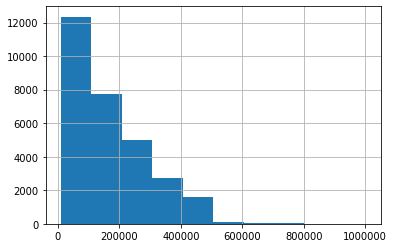

In [405]:
df.CreditLimit.hist()

In [449]:
total_default_pcnt = df['Default'].sum()/len(df.Default)
print('Average chance of default: ' + str(total_default_pcnt * 100) + '%')

Average chance of default: 22.31343535691362%


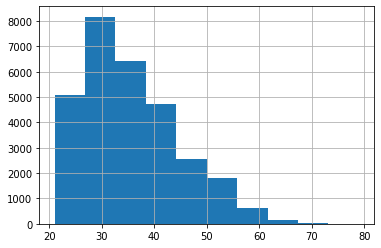

In [408]:
df.Age.hist()

In [441]:
gender_df = pd.DataFrame(df.groupby(['Gender', 'Default']).size().unstack())
gender_df.plot(kind='bar', stacked = True)


In [442]:
gender_df['percentage_defaulted'] = round((gender_df[1]/(gender_df[0] + gender_df[1]))*100, 3)
gender_df

Default,0,1,percentage_defaulted
Gender,,,
female,14111,3744,20.969
male,8885,2861,24.357


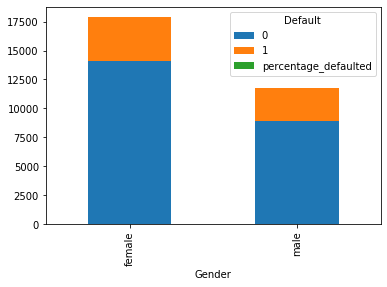

In [443]:
gender_df.plot(kind='bar', stacked = True)

In [451]:
education_df = pd.DataFrame(df.groupby(['Education', 'Default']).size().unstack())
education_df['percentage_defaulted'] = round((education_df[1]/(education_df[0] + education_df[1]))*100, 3)

education_df

Default,0,1,percentage_defaulted
Education,,,
graduate school,8545,2036,19.242
high school,3640,1233,25.303
others,116,7,5.691
university,10695,3329,23.738


In [413]:
df.Education.value_counts()

university         14024
graduate school    10581
high school         4873
others               123
Name: Education, dtype: int64

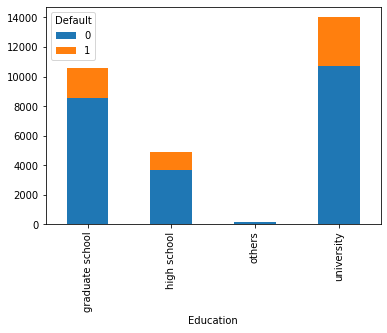

In [414]:
education_df.plot(kind='bar', stacked = True)

In [ ]:
# Getting Dummies for Categorical Variables

df = pd.get_dummies(df)

In [ ]:
# Here I decided to change the negative status of repayment each month to 0 if no interest is paid, keeping the lags the same from then 
# on out.

fil = (df.RepayStatApr == -2) | (df.PAY_1 == -1) | (df.PAY_1 == 0)
df.loc[fil, 'PAY_1'] = 0
fil = (df.RepayStatMay == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0)
df.loc[fil, 'PAY_2'] = 0
fil = (df.RepayStatJun == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0)
df.loc[fil, 'PAY_3'] = 0
fil = (df.RepayStatJul == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0)
df.loc[fil, 'PAY_4'] = 0
fil = (df.RepayStatAug == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0)
df.loc[fil, 'PAY_5'] = 0
fil = (df.RepayStatSep == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0)
df.loc[fil, 'PAY_6'] = 0
late = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(late, late.columns, 2, 3, 10)